## Import required packages

In [0]:
# Download required packages
!pip -q install gdown missingno torch petastorm wandb

from petastorm.pytorch import DataLoader
# Disable petastorm.DataLoader annoying logger (enable when debugging)
import logging.config
logging.config.dictConfig({'version': 1, 'disable_existing_loggers': True})

%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark import SparkContext, SparkConf
from pyspark.sql.window import Window

from petastorm.spark import SparkDatasetConverter, make_spark_converter
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, 'file:///dbfs/tmp/petastorm/cache')

from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
import torch
import re
import torch.nn as nn
from typing import *
import datetime
import gdown
import dataclasses
from operator import itemgetter
from functools import partial

import wandb
wandb.login(key='147339090e59f6a02bed0fa3f938a2b1ecbc567c')

import tqdm as tq
def tqdm(*args, **kwargs):
  ''' Small trick to prevent tqdm printing newlines at each step. '''
  return tq.tqdm(*args, **kwargs, leave=True, position=0)

WARNING: You are using pip version 20.2.4; however, version 21.1.2 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command. 
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc

## Data aquisition
We retrieve our datasets and download them to a temporary directory in the driver node.

In [0]:
!rm -rf /tmp/data /tmp/__MACOSX
gdown.download('https://drive.google.com/uc?id=1ggmDp-AWFzbQReLG0pLpQE_3fO0C0RnM', '/tmp/data.zip', quiet=False)
!unzip -q /tmp/data.zip -d /tmp/
!rm /tmp/data.zip

Downloading...
From: https://drive.google.com/uc?id=1ggmDp-AWFzbQReLG0pLpQE_3fO0C0RnM
To: /tmp/data.zip
0.00B [00:00, ?B/s]4.72MB [00:00, 31.5MB/s]17.3MB [00:00, 40.9MB/s]25.7MB [00:00, 32.6MB/s]34.1MB [00:00, 38.0MB/s]42.5MB [00:01, 42.4MB/s]59.2MB [00:01, 57.0MB/s]71.9MB [00:01, 53.5MB/s]

Then we load the datasets to the DBFS.

In [0]:
dbutils.fs.mv("file:/tmp/data", "dbfs:/data", recurse=True)

Out[3]: True

In [0]:
%fs ls /data/

path,name,size
dbfs:/data/.DS_Store,.DS_Store,6148
dbfs:/data/key_stats_yahoo.csv,key_stats_yahoo.csv,2047081
dbfs:/data/prices/,prices/,0


In [0]:
%fs ls /data/

path,name,size
dbfs:/data/.DS_Store,.DS_Store,6148
dbfs:/data/key_stats_yahoo.csv,key_stats_yahoo.csv,2047081
dbfs:/data/prices/,prices/,0


## Dataset loading

We load the initial datasets into PySpark dataframes: one for fundamentals data and one for prices of every stock. We filter some selected stocks to make the execution feasible in short times on few nodes.

In [0]:
key_stats_df = spark.read.load("dbfs:/data/key_stats_yahoo.csv", 
                           format="csv",
                           sep=",",
                           inferSchema="true",
                           header="true"
                          )

chosen_stocks = ["aapl", "msft", "ge", "pfe", "t"]
key_stats_df = key_stats_df.drop(key_stats_df.columns[0])
# Filtering chosen stocks
stock_dfs = []
for stock in chosen_stocks:
    stock_dfs.append(key_stats_df.filter(key_stats_df["Ticker"] == stock))

key_stats_df = stock_dfs[0]
for i in range(1, len(stock_dfs)):
    key_stats_df = key_stats_df.unionAll(stock_dfs[i])

key_stats_df.schema['Date'].nullable = False

# Use legacy format to parse dates
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
key_stats_df = key_stats_df.withColumn("Date", F.to_date(key_stats_df["Date"], 'MM/dd/yyyy HH:mm'))

# Cast numerical columns to double
for column in key_stats_df.columns[2:]:
  key_stats_df = key_stats_df.withColumn(column, key_stats_df[column].cast("double"))

# Prices dataframes for every stock
stock_files =  list(map(lambda x: x + ".csv", chosen_stocks))
prices_files = [f.path for f in dbutils.fs.ls('/data/prices/') if f.path.lower().split("/")[-1] in stock_files]
dfs_names = [f.rsplit('/', 1)[1][:-len('.csv')] for f in prices_files]
prices_dfs = []
for f in tqdm(prices_files, desc='Reading stock price data', total=len(prices_files)):
  df = spark.read.load(
    f,
    format="csv",
    sep=",",
    inferSchema="true",
    header="true"
  )
  df = df.withColumn("Date", F.to_date(df["Date"], 'dd-MM-yyyy'))
  df.schema['Date'].nullable = False
  prices_dfs.append(df)

Reading stock price data: 0%| | 0/5 [00:00<?, ?it/s]Reading stock price data: 20%|██ | 1/5 [00:01<00:06, 1.64s/it]Reading stock price data: 40%|████ | 2/5 [00:03<00:04, 1.52s/it]Reading stock price data: 60%|██████ | 3/5 [00:04<00:02, 1.40s/it]Reading stock price data: 80%|████████ | 4/5 [00:05<00:01, 1.33s/it]Reading stock price data: 100%|██████████| 5/5 [00:06<00:00, 1.27s/it]Reading stock price data: 100%|██████████| 5/5 [00:06<00:00, 1.34s/it]

## Dataset analysis

In [0]:
print("Prices dataframe format:")
prices_dfs[0].printSchema()

Prices dataframe format:
root
-- Date: date (nullable = true)
-- Low: double (nullable = true)
-- Open: double (nullable = true)
-- Volume: double (nullable = true)
-- High: double (nullable = true)
-- Close: double (nullable = true)
-- Adjusted Close: double (nullable = true)

In [0]:
print("Key stats dataframe format:")
key_stats_df.printSchema()

Key stats dataframe format:
root
-- Date: date (nullable = true)
-- Ticker: string (nullable = true)
-- Price: double (nullable = true)
-- DE Ratio: double (nullable = true)
-- Trailing P/E: double (nullable = true)
-- Price/Sales: double (nullable = true)
-- Price/Book: double (nullable = true)
-- Profit Margin: double (nullable = true)
-- Operating Margin: double (nullable = true)
-- Return on Assets: double (nullable = true)
-- Return on Equity: double (nullable = true)
-- Revenue Per Share: double (nullable = true)
-- Market Cap: double (nullable = true)
-- Enterprise Value: double (nullable = true)
-- Forward P/E: double (nullable = true)
-- PEG Ratio: double (nullable = true)
-- Enterprise Value/Revenue: double (nullable = true)
-- Enterprise Value/EBITDA: double (nullable = true)
-- Revenue: double (nullable = true)
-- Gross Profit: double (nullable = true)
-- EBITDA: double (nullable = true)
-- Net Income Avl to Common : double (nullable = true)
-- Diluted EPS: double (nullable = true)
-- Earnings Growth: double (nullable = true)
-- Revenue Growth: double (nullable = true)
-- Total Cash: double (nullable = true)
-- Total Cash Per Share: double (nullable = true)
-- Total Debt: double (nullable = true)
-- Current Ratio: double (nullable = true)
-- Book Value Per Share: double (nullable = true)
-- Cash Flow: double (nullable = true)
-- Beta: double (nullable = true)

### Utility functions

Here are a some utility functions that are used across the notebook.

In [0]:
def prices_df_nan_summary(prices_dfs: List[pyspark.sql.DataFrame], names: List[str]) -> pd.DataFrame:
  ''' Utility function to summarize columns that have missing values. '''
  nan_dfs = []
  for prices_df, name in tqdm(zip(prices_dfs, names), total=len(prices_dfs), desc='Generating prices summary ...'):
    nan_absolute = prices_df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in prices_df.columns]).first()
    if any(nan_absolute):
      # Simple conversion from Pyspark row -> Python set of values
      values = set(nan_absolute.asDict().values()).difference({0})
      # Either we don't have values for that row, or we have all of them (but Date which is non-nullable)
      # Values contains the no. of NaN values and 0 in correspondance of the Date column
      assert len(values) == 1
      nan_count = values.pop()
      nan_dfs.append((name, round(100*nan_count/prices_df.count(), 3), nan_count))

  return pd.DataFrame(nan_dfs, columns=['Stock name', 'Missing data (%)', 'Count'])

def remove_trailing_nan(df: pyspark.sql.DataFrame, ticker: str, col: str = 'Low') -> pyspark.sql.DataFrame:
  '''
    A trick to detect if the input DataFrame ends with a contiguous collection of NaN rows, returns the dataframe without them.
  '''
  # The total number of rows of the dataframe
  df_length = df.count()
  
  # Sort the input dataframe and add a new column to keep track of the relative position of each row
  df_sorted_id = df.sort('Date').withColumn('id', F.row_number().over(Window.orderBy('Date')))
  
  # Tricky part here: create a new column called 'cumsum' that will store the progressive number of consecutive NaN in our dataset.
  # Let's break it into smaller parts:
  # 1) create an index generator that will partition by 'Low' values [(...,Null...), (...,value1,...), (...,value2...), ... (...)] and within rows order by date
  # Example:
  ## |2019-06-05|null|null|  null|null| null|          null|624|        21|
  ## |2019-06-06|null|null|  null|null| null|          null|625|        22|
  ## |2019-06-07|null|null|  null|null| null|          null|626|        23| <- last column is the cumulative sum (i.e. the number of consecutive NaN)
  ## ...
  ## |2019-05-09|23.2|11.5|   7.3|4.2|  16.2|          29.1|1  |         0|
  ## |2019-05-10|23.2|11.5|   7.3|4.2|  16.2|          29.1|2  |         0|
  # 2) assign to each row a progressive index starting from 1 if it has null in correspondance of Low, zero otherwise
  # 3) store these values into a new column called cumsum (i.e. it behaves like pandas cumsum)
  # 4) at the end, the row whose ID corresponds to the length of the dataframe will contain at column 'cumsum' the no. of trailing NaN values.
  cumsum_df = df_sorted_id.withColumn('cumsum', F.when(F.isnull(df_sorted_id.Low), F.row_number().over(Window.partitionBy('Low').orderBy('Date'))).otherwise(0))

  # Retrieve the "last" row and read the value of cumsum
  end_idx = cumsum_df.where(cumsum_df['id'] == df_length).first().cumsum
  
  # Retain rows whose index is lower len(df) - end_idx + 1 (i.e. cut trailing NaN values)
  return df_sorted_id.where(df_sorted_id['id'] <= df_length-end_idx+1)


def merge_prices_fundamentals(
    prices_dfs: List[pyspark.sql.DataFrame],
    key_stats_df: pyspark.sql.DataFrame,
    dfs_names: List[str],
    drop_cols: List[str] = ['Date', 'Ticker', 'Price']
    ) -> List[pyspark.sql.DataFrame]:
  # Define the target list of dataframes
  prices_dfs_new = []
  for ticker in tqdm(key_stats_df.select('Ticker').distinct().collect(), desc='Merging the datasets ...'):
    ticker = ticker[0]
    # Consider only stocks for which we have fundamental data
    if ticker.upper() not in dfs_names: continue
      
    # The prices dataframe associated to the current ticker
    prices_df_idx = dfs_names.index(ticker.upper())
    prices_df = prices_dfs[prices_df_idx]
    
    # Retrieve financial reports for the current ticker
    ticker_df = key_stats_df.filter(F.col('Ticker') == ticker)
    
    # Perform an inner join between the two dataframes, we first take all reports
    # whose date is at most the prices date (then we will take the latest available)
    joined_df = ticker_df.join(prices_df, ticker_df.Date <= prices_df.Date, how='inner')
    
    # Let's break this into smaller parts:
    # 1) Add a new column for the date latest available report for that stock. To do that
    #    we partition over **prices** Date using the Window object, and the the max over
    #    **ticker** Date.
    # 2) Retain those columns whose financial report date is the same as in ticker_df_max_date
    # 3) Finally drop the **ticker** Date and other unused columns
    joined_df = joined_df.withColumn('ticker_df_max_date', F.max(ticker_df['Date'])\
                      .over(Window.partitionBy(prices_df['Date'])))\
                      .where(ticker_df['Date'] == F.col('ticker_df_max_date'))\
                      .drop('ticker_df_max_date', 'High', 'Low', 'Open', 'Close')\
                      .drop(ticker_df['Date'])\
                      
    # Return the usual list of dataframes
    prices_dfs_new.append(joined_df)
    
  return prices_dfs_new
    
                
def fill_missing_days(
  aggregate_dfs: List[pyspark.sql.DataFrame],
  remove_weekends: bool = True,
  end_date: str = '2014-01-01'
) -> List[pyspark.sql.DataFrame]:
  result_dfs = []
  
  @udf("boolean")
  def is_weekday(date: datetime) -> bool:
      ''' Returns true if the provided date corresponds to a weekday. '''
      return date.weekday() < 5
    
  for df in tqdm(aggregate_dfs, desc='Filling missing days ...'):
    # In this case we apply the following steps in order to apply fill-forward to our dataset:
    # 1) define a Window object the will over the dataset sorted with decreasing dates
    # 2) compute the difference in days between consecutive rows (11/05/2021 - 07/05/2021 ==> 4 days)
    #    and store it in a column named diff
    # 3) compute an increasing index in the column seq that is the days gap we need to fill
    # Example:
    # |Date      | Adjusted close   |diff|seq|new_date  |
    # |2021-04-09|116.80999755859375|   3|  1|2021-04-11|
    # |2021-04-09|116.80999755859375|   3|  2|2021-04-10|
    # |2021-04-09|116.80999755859375|   3|  3|2021-04-09|
    # 4) create a new column new_date as the result of the computation F.col('Date') + F.col('diff') - F.col('seq')
    # 5) only retain rows whose date is before the provided end_date
    #
    # N.B. if we want to bfill the values we should instead consider the dataframes with dates in ascending order,
    # and subtract the value of F.col('diff') instead of summing it. Other parts of the code stays the same.
    df = df\
    .withColumn('diff', F.datediff(F.lag(F.col('Date'),1).over(Window.orderBy(F.desc('Date'))), F.col('Date')))\
    .withColumn('seq', F.explode(F.sequence(F.lit(1), F.col("diff"))))\
    .withColumn('new_date', (F.col('Date') + F.col('diff') - F.col('seq')))\
    .where(F.col('new_date') < pd.Timestamp(end_date))
    
    # If specified, remove weekends that are most likely created by us as synthetic data with the ffill technique
    if remove_weekends:
      df = df.where(is_weekday(F.col('new_date')))
      
    # Drop unecessary columns
    df = df.drop('Date', 'diff', 'seq').withColumnRenamed('new_date', 'Date')
    
    # If the dataframe is actually non-empty, add it to the list of resulting dataframes
    if df.count() > 0:
      result_dfs.append(df)
  return result_dfs

def missing_values_summary(df):
  ''' Returns a utility summary to view missing values in our dataframe. '''
  n = df.count()
  
  def to_percentage(x: pyspark.sql.column.Column, n: int) -> int:
    ''' Utility function to compute the amount of missing values as a percentage of the original dataframe. '''
    return F.round(100 * x / n, 3)
  
  # Aggregate using the count function over null values, and return a view over the obtained (single row) dataframe
  return df.agg(*[to_percentage(F.count(F.when(F.isnull(c), c)), n).alias(c) for c in df.columns]).first()

def scale_features(dfs: List[pyspark.sql.DataFrame]):
    ''' Scales the numerical features to unit variance. '''
    
    scalable_features = ['DE Ratio', 'Trailing P/E', 'Price/Sales', 'Price/Book',
       'Profit Margin', 'Operating Margin', 'Return on Assets',
       'Return on Equity', 'Revenue Per Share', 'Market Cap',
       'Enterprise Value', 'PEG Ratio', 'Enterprise Value/Revenue',
       'Enterprise Value/EBITDA', 'Revenue', 'Gross Profit', 'EBITDA',
       'Net Income Avl to Common ', 'Diluted EPS', 'Earnings Growth',
       'Revenue Growth', 'Total Cash', 'Total Cash Per Share', 'Total Debt',
       'Current Ratio', 'Book Value Per Share', 'Cash Flow', 'Beta', 'Volume',
       'Adjusted Close', 'SMA', 'RSI']
    

    # Aggregating dfs in a single one
    aggregate_df = dfs[0]
    for df in tqdm(dfs[1:], desc='Performing dfs union ...'):
      aggregate_df = aggregate_df.union(df)
      
    # Computing means and stds for every column of the aggregate df
    mean = aggregate_df.select(
      [F.mean(F.col(column)) for column in scalable_features]
    ).collect()[0]
    
    std = aggregate_df.select(
      [F.stddev(F.col(column)) for column in scalable_features]
    ).collect()[0]
    
    #summary = aggregate_df.select(scalable_features).summary("mean", "stddev")
    #mean = summary.filter(summary["summary"] == "mean")#.select(scalable_features)
    #std = summary.filter(summary["summary"] == "std")
    #print(mean)

    
    for i in tqdm(range(len(dfs)), desc='Scaling numerical features ...'):
      # Scaling scalable features
      for j, feature in enumerate(scalable_features):
        dfs[i] = dfs[i].withColumn(feature, (dfs[i][feature]-mean[j])/std[j])
        #dfs[i] = dfs[i].withColumn(feature, (dfs[i][feature]-mean[feature])/std[feature])
    return mean[-3], std[-3]
        
def impute_missing_values(
  prices_dfs_new: List[pyspark.sql.DataFrame],
  key_stats_df: pyspark.sql.DataFrame
) -> Tuple[List[pyspark.sql.DataFrame], pyspark.sql.DataFrame]:
  # define the window
  window = Window.orderBy('Date').rowsBetween(Window.unboundedPreceding, 0)

  # Forward filling values 
  # (ref. https://stackoverflow.com/questions/38131982/forward-fill-missing-values-in-spark-python/50422240#50422240)
  for i in range(len(prices_dfs_new)):
    for col_name in prices_dfs_new[i].schema.names:
      col = F.last(prices_dfs_new[i][col_name], ignorenulls=True).over(window)
      prices_dfs_new[i] = prices_dfs_new[i].withColumn(col_name, col)

  # In this case this dataframe contains financial reports that may contain NaN values either because that
  # metric was not available at that time OR because it was monitoring an initial stage of a company growth.
  # What we do is to apply the classic fast-forward, and fill initial missing values with zeroes.
  # Please note: we also discard the 'Forward P/E' column since the imputation here would introduce too much noise.
  key_stats_df_new = key_stats_df.drop('Forward P/E')
  for col_name in key_stats_df_new.schema.names:
      col = F.last(key_stats_df_new[col_name], ignorenulls=True).over(window)
      key_stats_df_new = key_stats_df_new.withColumn(col_name, col)
  key_stats_df_new = key_stats_df_new.fillna(0.)
  
  return prices_dfs_new, key_stats_df_new

def from_dfs(
  dfs: List[pyspark.sql.DataFrame],
  window_size: int = 3,
  target_col: str = 'Adjusted Close',
  val_date: str = '2012-01-01',
  test_date: str = '2013-01-01'
):
  # Split the dataset into train/val/test using these dates as boundaries
  val_begin = pd.Timestamp(val_date)
  test_begin = pd.Timestamp(test_date)
  
  def should_drop(col: pyspark.sql.column, idx: int) -> bool:
    ''' Returns whether the provided column should be dropped. '''
    return (col.endswith(f'_{idx}') or 'Ticker' in col or 'Date' in col or 'id' in col)\
              and col != f'Adjusted Close_{idx}'

  train_split, val_split, test_split = [], [], []
  
  for df in tqdm(dfs, desc='Loading dataset from dfs ...'):
    # Create an ID for each row based on dates
    df = df\
      .sort('Date')\
      .withColumn('id', F.row_number().over(Window.orderBy('Date')))
    
    # Split the stock dataset into train/dev/test splits
    train_df = df.where(F.col('Date') < val_begin)
    val_df = df.where(F.col('Date').between(val_begin, test_begin-pd.Timedelta(days=1)))
    test_df = df.where(F.col('Date') >= test_begin)
    
    # Add a unique identifier for each column (e.g. Date -> Date_0, Date_1, etc ...)
    train_df = prepend_columns_index(train_df)
    val_df = prepend_columns_index(val_df)
    test_df = prepend_columns_index(test_df)
    
    # Convert each split from nxm -> nxm*(w+1), where w is the size of the window
    train_df = create_window_indexes(train_df, window_size)
    val_df = create_window_indexes(val_df, window_size)
    test_df = create_window_indexes(test_df, window_size)
    
    # Collect the processed datasets
    train_split.append(train_df)
    val_split.append(val_df)
    test_split.append(test_df)
  
  # Initialize the final datasets using the obtained df schema
  train_ds = spark.createDataFrame([], train_split[0].schema)
  val_ds = spark.createDataFrame([], val_split[0].schema)
  test_ds = spark.createDataFrame([], test_split[0].schema)
  
  # Collect all the dataframes into a single df for each data split
  for df in train_split: train_ds = train_ds.union(df)
  for df in val_split: val_ds = val_ds.union(df)
  for df in test_split: test_ds = test_ds.union(df)
  
  # Drop unused columns for the target variable and rename the target column as 'y'
  drop_cols = [col for col in test_ds.columns if should_drop(col, window_size)]
  train_ds = train_ds.drop(*drop_cols).withColumnRenamed(f'Adjusted Close_{window_size}', 'y')
  val_ds = val_ds.drop(*drop_cols).withColumnRenamed(f'Adjusted Close_{window_size}', 'y')
  test_ds = test_ds.drop(*drop_cols).withColumnRenamed(f'Adjusted Close_{window_size}', 'y')
  
  # Rename columns to make them compatible with Apache Parquet format
  target_cols = list(map(lambda x: '_'.join(re.split(' |/', x)), train_ds.columns))
  for c, target in zip(train_ds.columns, target_cols): train_ds = train_ds.withColumnRenamed(c, target)
  for c, target in zip(val_ds.columns, target_cols): val_ds = val_ds.withColumnRenamed(c, target)
  for c, target in zip(test_ds.columns, target_cols): test_ds = test_ds.withColumnRenamed(c, target)
    
  # Compute the set of unique features in each split
  features = list(set(c[:-2] for c in train_ds.columns if len(c) >= 2))

  # Convert each split to have, at each timestep (column), the collection of features at that timestep
  for timestep in tqdm(range(window_size), desc='Creating timesteps ...'):
    # Consider all the features in this timestep
    current_cols = list(map(lambda c: f'{c}_{timestep}', features))
    # Convert (price_0, sma_0, market_cap_0) -> 0: (price|sma|market_cap) 
    train_ds = train_ds.withColumn(f'x_{timestep}', F.array(current_cols)).drop(*current_cols)
    val_ds = val_ds.withColumn(f'x_{timestep}', F.array(current_cols)).drop(*current_cols)
    test_ds = test_ds.withColumn(f'x_{timestep}', F.array(current_cols)).drop(*current_cols)
  
  return train_ds, val_ds, test_ds, features

def prepend_columns_index(
  df: pyspark.sql.DataFrame,
  idx: int = 0
) -> pyspark.sql.DataFrame:
  ''' Utility function that returns a new dataframe where columns are preceeded by [idx]. '''
  for col in df.schema.names:
    # If this is not the first time this function is applied, simply edit the previous identifier
    new_col = f'{col}_{idx}' if idx == 0 else f'{col[:-2]}_{idx}'
    df = df.withColumnRenamed(col, new_col)
  return df

def create_window_indexes(df: pyspark.sql.DataFrame, window_size: int) -> pyspark.sql.DataFrame:
  ''' Apply self join multiple times to the input dataframe, return a new one of size (df.count(), len(df.columns)*window_size) '''
  joined_df = df
  for win_idx in range(1, window_size+1):
    joined_df = joined_df.join(
      prepend_columns_index(df, win_idx),
      F.col('id_0') == F.col(f'id_{win_idx}') - win_idx
    )
  return joined_df

def collate_fn(
  time_steps: List[str],
  batch: List[Dict[str, np.array]]
) -> Tuple[torch.Tensor, torch.Tensor]:
  ''' Returns (x, y) pairs where x is a vector of shape: (window_size, feature_size). '''
  X = np.asarray([np.stack(itemgetter(*time_steps)(d)) for d in batch])
  Y = np.asarray([d['y'] for d in batch])
  return torch.from_numpy(X).double(), torch.from_numpy(Y).double()

def data_loader_fn(window_size: int, **kwargs) -> DataLoader:
  ''' Override default behaviour and return a petastorm.Dataset with custom collate function. '''
  time_steps = [f'x_{time_step}' for time_step in range(window_size)]
  return DataLoader(**kwargs, collate_fn=partial(collate_fn, time_steps))

def r2_score(y_hat: np.ndarray, y: np.ndarray) -> float:
  ''' Computes the R Squared coefficient between y_hat and y. '''
  rss = torch.sum((y - y_hat) ** 2)
  tss = torch.sum((y - y.mean()) ** 2)
  return 1 - rss / tss

def adjusted_r2_score(y_hat: np.ndarray, y: np.ndarray, p: int) -> float:
  ''' Computes the Adjusted R Squared coefficient between y_hat and y. '''
  rss = torch.sum((y - y_hat) ** 2)
  tss = torch.sum((y - y.mean()) ** 2)
  df_e = y.shape[0] - p - 1
  df_t = y.shape[0] - 1
  adj_coef = df_t/df_e if df_t/df_e > 0 else 1  # sample size < features
  return 1 - (rss / tss) * adj_coef
  

def plot_loss_history(loss_history):
  ''' Plots the loss history. '''
  plt.plot(loss_history['train_history'], label='Train loss')
  plt.plot(loss_history['valid_history'], label='Valid loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc="upper right")
  plt.show()

#### Technical indicators

In [0]:
def add_sma(dfs: List[pyspark.sql.DataFrame], period: int = 10) -> None:
    ''' Computes the Simple Moving Average from a given dataframe. '''
    # Window of previous [period] days.
    w = (Window().orderBy(F.col("timestamp").cast('long')).rangeBetween(-period*86400, 0))
    for i in tqdm(range(len(dfs)), desc='Adding SMA ...'):
        # Adding temporary timestamp column
        dfs[i] = dfs[i].withColumn('timestamp', dfs[i].Date.cast('timestamp'))
        # Computing moving average over the window
        dfs[i] = dfs[i].withColumn(
          "SMA",
          F.avg("Adjusted Close").over(w)
        )
        # Dropping temporary columns
        dfs[i] = dfs[i].drop("timestamp")

        
def add_rsi(dfs: List[pyspark.sql.DataFrame], period: int = 14) -> None:
    ''' Computes the Relative Strength Index from a given dataframe. 
        Formula available at https://en.wikipedia.org/wiki/Relative_strength_index.
        Also adds overbought and oversold when the RSI index hits 70 or 30.'''
    for j in tqdm(range(len(dfs)), desc='Adding RSI ...'):
        
        #dateCol = dfs[j]["Date"]
        w = Window.orderBy("Date")

        # Lagging the adjusted close of one row (to have the price of the previous day)
        dfs[j] = dfs[j].withColumn("prev_adj_close", F.lag(dfs[j]["Adjusted Close"]).over(w))
        # Computing day gain and day loss
        dfs[j] = dfs[j].withColumn("current_gain", F.when(dfs[j]["Adjusted Close"] >= dfs[j]["prev_adj_close"],
                                                          dfs[j]["Adjusted Close"] - dfs[j]["prev_adj_close"])
                                                          .otherwise(0.0))
        dfs[j] = dfs[j].withColumn("current_loss", F.when(dfs[j]["prev_adj_close"] >= dfs[j]["Adjusted Close"],
                                                         dfs[j]["prev_adj_close"] - dfs[j]["Adjusted Close"])
                                                         .otherwise(0.0))
        
        # Adding temporary timestamp column
        dfs[j] = dfs[j].withColumn('timestamp', dfs[j].Date.cast('timestamp'))
        # Window of previous [period] days.
        w = (Window().orderBy(F.col("timestamp").cast('long')).rangeBetween(-period*86400, 0))
        # Computing moving averages of day gain and day loss over the window
        dfs[j] = dfs[j].withColumn(
          "smmau",
          F.avg("current_gain").over(w)
        )
        
        dfs[j] = dfs[j].withColumn(
          "smmad",
          F.avg("current_loss").over(w)
        )
        
        # Computing RSI given the moving averages
        dfs[j] = dfs[j].withColumn("RSI", F.when(dfs[j]["smmau"] == 0.0, 50.0).when(dfs[j]["smmad"] == 0.0, 50.0).otherwise(100 - (100/(1+(dfs[j]["smmau"]/dfs[j]["smmad"])))))            
        # Adding overbought and oversold signals when the RSI goes above 70 and below 30
        dfs[j] = dfs[j].withColumn("Overbought", F.when(dfs[j]["RSI"] >= 70, 1.0).otherwise(0.0))
        dfs[j] = dfs[j].withColumn("Oversold", F.when(dfs[j]["RSI"] <= 30, 1.0).otherwise(0.0))
        #dfs[j] = dfs[j].withColumn("Date", dateCol)
        
        # Dropping temporary columns
        dfs[j] = dfs[j].drop("prev_adj_close", "current_gain", "current_loss", "smmau", "smmad", "timestamp")
        
def fit_evaluate(
  model_name: str,
  window_size: int,
  train_df: pyspark.sql.DataFrame,
  test_df: pyspark.sql.DataFrame
) -> None:
  ''' Fits a model on train data and evaluate on test data. '''
  features = [f'x_{time_step}' for time_step in range(window_size)]
  train_df = train_df.withColumn('x', F.concat(*features)).drop(*features)
  test_df = test_df.withColumn('x', F.concat(*features)).drop(*features)
  
  list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
  train_df_x = list_to_vector_udf(train_df['x']).alias('x')
  test_df_x = list_to_vector_udf(test_df['x']).alias('x')
  
  train_df = train_df.select(train_df_x, train_df['y'])
  test_df = test_df.select(test_df_x, test_df['y'])
  if model_name == 'RandomForestRegressor':
    _model = RandomForestRegressor(featuresCol='x', labelCol='y')
  elif model_name == 'DecisionTreeRegressor':
    _model = DecisionTreeRegressor(featuresCol='x', labelCol='y')

  model = _model.fit(train_df)
  
  predicted_values = model.transform(test_df)
  evaluator = RegressionEvaluator(labelCol="y", predictionCol="prediction", metricName="r2")
  r2 = evaluator.setMetricName('r2').evaluate(predicted_values)
  mse = evaluator.setMetricName('mse').evaluate(predicted_values)
  
  print(f'Performance with {model_name}')
  print('R2: {:.3f}, MSE: {:.3f}'.format(r2, mse))
  
  return predicted_values

def evaluate_trading_strategy_ps(
  predicted_values: pyspark.sql.DataFrame,
  features: List[str],
  hparams,
  price_std: float,
  price_mean: float,
  target_feature: str = 'Adjusted_Close'
) -> None:
  ''' Evaluate the trading strategy of PySpark models given their predictions. '''
  target_idx = features.index(target_feature)
  preds = predicted_values.collect()
  X, y, y_pred = map(np.array, zip(*preds))
  X = X.reshape(-1, hparams.window_size, hparams.input_dim)

  pnl = 0.0
  correct = 0
  tries = 0
  X[:, :, target_idx] = X[:, :, target_idx] * price_std + price_mean
  y_pred = y_pred * price_std + price_mean
  y = y * price_std + price_mean
  for i in range(X.shape[0]):
    # Increase predicted
    current_price = X[i, -1, target_idx]
    ret = 0.0
    if current_price < y_pred[i]:
      # Adding long profit / loss
      ret = (y[i] - current_price) / current_price

      pnl += ret
      # Counting correct operations 
      tries += 1
      correct += 1 if ret >= 0 else 0

  print(f"1-year profit: {(pnl.item())*100}%")
  print(f"Operation accuracy: {(correct/tries)*100}%")

@torch.no_grad()
def evaluate_trading_strategy(
  model: nn.Module,
  test_dataloader: DataLoader,
  mean: float,
  std: float,
  stock_num: int,
  target_idx: int = -1
) -> None:
  pnl = 0.0
  tries = 0
  correct = 0
  for X, y in test_dataloader:
    y_pred = model(X.float())
    # Re-adding mean to prices to make them positive
    X[:, :, target_idx] = X[:, :, target_idx] * std + mean
    y_pred = y_pred * std + mean
    y = y * std + mean
    for i in range(X.shape[0]):
      # Increase predicted
      current_price = X[i, -1, target_idx]
      ret = 0.0
      if current_price < y_pred[i]:
        # Adding long profit / loss
        ret = (y[i] - current_price) / current_price
        
        pnl += ret
        # Counting correct operations 
        tries += 1
        correct += 1 if ret >= 0 else 0

  print(f"1-year profit: {(pnl)*100}%")
  print(f"Operation accuracy: {(correct/tries)*100}%")

In [0]:
print("Overview of the missing values in the key_stats dataframe\n")
key_stats_summary = missing_values_summary(key_stats_df)
key_stats_summary

Overview of the missing values in the key_stats dataframe

Out[11]: Row(Date=0.0, Ticker=0.0, Price=2.326, DE Ratio=17.674, Trailing P/E=0.93, Price/Sales=0.0, Price/Book=0.465, Profit Margin=0.0, Operating Margin=0.0, Return on Assets=1.86, Return on Equity=1.86, Revenue Per Share=0.0, Market Cap=0.0, Enterprise Value=1.395, Forward P/E=40.465, PEG Ratio=0.0, Enterprise Value/Revenue=1.395, Enterprise Value/EBITDA=3.256, Revenue=1.395, Gross Profit=0.465, EBITDA=2.791, Net Income Avl to Common =0.0, Diluted EPS=0.465, Earnings Growth=5.116, Revenue Growth=3.256, Total Cash=0.465, Total Cash Per Share=0.465, Total Debt=8.372, Current Ratio=9.302, Book Value Per Share=0.93, Cash Flow=10.233, Beta=2.791)

### Missing values imputation

In [0]:
summary = prices_df_nan_summary(prices_dfs, dfs_names)
px.bar(summary, x='Stock name', y='Missing data (%)', hover_data=['Count'], title="Stock price dataset before preprocessing (only columns with missing values are displayed)")

Generating prices summary ...: 0%| | 0/5 [00:00<?, ?it/s]Generating prices summary ...: 20%|██ | 1/5 [00:02<00:08, 2.07s/it]Generating prices summary ...: 40%|████ | 2/5 [00:03<00:05, 1.87s/it]Generating prices summary ...: 60%|██████ | 3/5 [00:05<00:03, 1.58s/it]Generating prices summary ...: 80%|████████ | 4/5 [00:06<00:01, 1.36s/it]Generating prices summary ...: 100%|██████████| 5/5 [00:07<00:00, 1.40s/it]Generating prices summary ...: 100%|██████████| 5/5 [00:07<00:00, 1.50s/it]
Out[12]:

For most of the above stocks with missing values, we noticed that they indeed exist up to a given time and after that no more data is available. It may due to a business failure, hence no more stocks will be exchanged from that moment on.

In [0]:
# Clear our input data from training NaN values
prices_dfs_new = [remove_trailing_nan(df,name) for df,name in tqdm(zip(prices_dfs, dfs_names), total=len(prices_dfs), desc='Removing trailing NaN values ...')]

summary = prices_df_nan_summary(prices_dfs_new, dfs_names)
px.bar(summary, x='Stock name', y='Missing data (%)', hover_data=['Count'], title="Stock price dataset after preprocessing (only columns with missing values are displayed)")

Removing trailing NaN values ...: 0%| | 0/5 [00:00<?, ?it/s]Removing trailing NaN values ...: 20%|██ | 1/5 [00:03<00:14, 3.59s/it]Removing trailing NaN values ...: 40%|████ | 2/5 [00:06<00:09, 3.08s/it]Removing trailing NaN values ...: 60%|██████ | 3/5 [00:08<00:05, 2.79s/it]Removing trailing NaN values ...: 80%|████████ | 4/5 [00:11<00:02, 2.58s/it]Removing trailing NaN values ...: 100%|██████████| 5/5 [00:13<00:00, 2.57s/it]Removing trailing NaN values ...: 100%|██████████| 5/5 [00:13<00:00, 2.71s/it]
Generating prices summary ...: 0%| | 0/5 [00:00<?, ?it/s]Generating prices summary ...: 20%|██ | 1/5 [00:03<00:13, 3.34s/it]Generating prices summary ...: 40%|████ | 2/5 [00:05<00:07, 2.52s/it]Generating prices summary ...: 60%|██████ | 3/5 [00:07<00:04, 2.18s/it]Generating prices summary ...: 80%|████████ | 4/5 [00:08<00:01, 1.90s/it]Generating prices summary ...: 100%|██████████| 5/5 [00:10<00:00, 1.99s/it]Generating prices summary ...: 100%|██████████| 5/5 [00:10<00:00, 2.13s/it]
Out[13]:

At this point we use the fast forward imputation technique to fill-in missing values. Please note that in this case missing values are mostly due to holidays or periods when stocks are not exchanged.

## Hyperparameters

In [0]:
@dataclasses.dataclass
class HParams:
  input_dim: int = -1  # Denoted by data transformations
  window_size: int = 10
  batch_size: int = 1024
  features: int = -1  # Denoted by data transformations
  hidden_dim: int = 128
  num_layers: int = 1
  dropout: int = 0.5
  lr: int = 0.1
    
hparams = HParams()

## Building our new dataset

We impute missing values, merge the two datasets, fill missing days and compute additional features (e.g. RSI).

In [0]:
# Impute missing values in the prices dataset (i.e. fast-forward last valid values)
prices_dfs_new, key_stats_df_new = impute_missing_values(prices_dfs_new, key_stats_df)

# Merge the stock price dataset with fundamental data of the relative company
aggregate_dfs = merge_prices_fundamentals(prices_dfs_new, key_stats_df_new, dfs_names)

# Fill gaps from the original dataset
dfs = fill_missing_days(aggregate_dfs)
                  
# Add SMA indicator to each dataframe
add_sma(dfs)

# Add RSI indicator to each dataframe
add_rsi(dfs)

# Scale numerical features
price_mean, price_std = scale_features(dfs)

# Create train/dev/test splits
train_ds, val_ds, test_ds, features = from_dfs(dfs, window_size=hparams.window_size)
hparams.input_dim = len(features)
hparams.features = features

Merging the datasets ...: 0%| | 0/5 [00:00<?, ?it/s]Merging the datasets ...: 20%|██ | 1/5 [00:00<00:01, 3.13it/s]Merging the datasets ...: 40%|████ | 2/5 [00:00<00:00, 4.66it/s]Merging the datasets ...: 60%|██████ | 3/5 [00:00<00:00, 4.68it/s]Merging the datasets ...: 80%|████████ | 4/5 [00:00<00:00, 5.47it/s]Merging the datasets ...: 100%|██████████| 5/5 [00:00<00:00, 6.16it/s]Merging the datasets ...: 100%|██████████| 5/5 [00:00<00:00, 5.35it/s]
Filling missing days ...: 0%| | 0/5 [00:00<?, ?it/s]Filling missing days ...: 20%|██ | 1/5 [00:06<00:25, 6.47s/it]Filling missing days ...: 40%|████ | 2/5 [00:12<00:18, 6.04s/it]Filling missing days ...: 60%|██████ | 3/5 [00:16<00:10, 5.26s/it]Filling missing days ...: 80%|████████ | 4/5 [00:20<00:04, 4.67s/it]Filling missing days ...: 100%|██████████| 5/5 [00:25<00:00, 4.95s/it]Filling missing days ...: 100%|██████████| 5/5 [00:25<00:00, 5.15s/it]
Adding SMA ...: 0%| | 0/5 [00:00<?, ?it/s]Adding SMA ...: 20%|██ | 1/5 [00:00<00:00, 6.53it/s]Adding SMA ...: 60%|██████ | 3/5 [00:00<00:00, 11.66it/s]Adding SMA ...: 100%|██████████| 5/5 [00:00<00:00, 14.01it/s]Adding SMA ...: 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]
Adding RSI ...: 0%| | 0/5 [00:00<?, ?it/s]Adding RSI ...: 20%|██ | 1/5 [00:00<00:02, 1.86it/s]Adding RSI ...: 40%|████ | 2/5 [00:01<00:01, 1.99it/s]Adding RSI ...: 60%|██████ | 3/5 [00:01<00:01, 1.96it/s]Adding RSI ...: 80%|████████ | 4/5 [00:01<00:00, 2.14it/s]Adding RSI ...: 100%|██████████| 5/5 [00:02<00:00, 2.26it/s]Adding RSI ...: 100%|██████████| 5/5 [00:02<00:00, 2.14it/s]
Performing dfs union ...: 0%| | 0/4 [00:00<?, ?it/s]Performing dfs union ...: 75%|███████▌ | 3/4 [00:00<00:00, 28.49it/s]Performing dfs union ...: 100%|██████████| 4/4 [00:00<00:00, 21.42it/s]
Scaling numerical features ...: 0%| | 0/5 [00:00<?, ?it/s]Scaling numerical features ...: 20%|██ | 1/5 [00:01<00:05, 1.34s/it]Scaling numerical features ...: 40%|████ | 2/5 [00:02<00:03, 1.23s/it]Scaling numerical features ...: 60%|██████ | 3/5 [00:03<00:02, 1.22s/it]Scaling numerical features ...: 80%|████████ | 4/5 [00:04<00:01, 1.12s/it]Scaling numerical features ...: 100%|██████████| 5/5 [00:05<00:00, 1.01it/s]Scaling numerical features ...: 100%|██████████| 5/5 [00:05<00:00, 1.08s/it]
Loading dataset from dfs ...: 0%| | 0/5 [00:00<?, ?it/s]Loading dataset from dfs ...: 20%|██ | 1/5 [00:17<01:09, 17.35s/it]Loading dataset from dfs ...: 40%|████ | 2/5 [00:31<00:46, 15.59s/it]Loading dataset from dfs ...: 60%|██████ | 3/5 [00:45<00:29, 14.76s/it]Loading dataset from dfs ...: 80%|████████ | 4/5 [00:59<00:14, 14.43s/it]Loading dataset from dfs ...: 100%|██████████| 5/5 [01:13<00:00, 14.18s/it]Loading dataset from dfs ...: 100%|██████████| 5/5 [01:13<00:00, 14.63s/it]
Creating timesteps ...: 0%| | 0/10 [00:00<?, ?it/s]Creating timesteps ...: 10%|█ | 1/10 [00:03<00:27, 3.06s/it]Creating timesteps ...: 20%|██ | 2/10 [00:05<00:23, 2.96s/it]Creating timesteps ...: 30%|███ | 3/10 [00:08<00:20, 2.95s/it]Creating timesteps ...: 40%|████ | 4/10 [00:12<00:18, 3.03s/it]Creating timesteps ...: 50%|█████ | 5/10 [00:14<00:14, 2.98s/it]Creating timesteps ...: 60%|██████ | 6/10 [00:17<00:11, 2.97s/it]Creating timesteps ...: 70%|███████ | 7/10 [00:20<00:08, 2.94s/it]Creating timesteps ...: 80%|████████ | 8/10 [00:23<00:05, 2.90s/it]Creating timesteps ...: 90%|█████████ | 9/10 [00:26<00:02, 2.98s/it]Creating timesteps ...: 100%|██████████| 10/10 [00:30<00:00, 3.24s/it]Creating timesteps ...: 100%|██████████| 10/10 [00:30<00:00, 3.06s/it]

##LSTM definition

Here we define the LSTM model, using the PyTorch deep learning framework.

In [0]:
class SimpleLSTM(nn.Module):
  def __init__(self, hparams):
      super().__init__()
      self.hparams = hparams
      self.lstm = nn.LSTM(hparams.input_dim, hparams.hidden_dim, num_layers=hparams.num_layers, batch_first=True)
      self.fc1 = nn.Linear(hparams.hidden_dim, hparams.hidden_dim//2)
      self.fc2 = nn.Linear(hparams.hidden_dim//2, 1)
      self.dropout = nn.Dropout(hparams.dropout)

  def forward(self, x: np.ndarray):
      x, (h,c) = self.lstm(x)
      x = torch.relu(self.fc1(x[:,-1]))
      x = self.fc2(x)
      return x.squeeze()

def train(
  model: nn.Module,
  optimizer: torch.optim.SGD,
  train_dataloader: DataLoader,
  valid_dataloader: DataLoader,
  logger,
  epochs: int = 5
) -> None:
  train_history = []
  valid_history = []
  mean_r2 = 0.0
  mean_adjusted_r2 = 0.0
  best_r2 = 0
  best_adj_r2 = 0
  model_state = model.state_dict().copy()
  best_epoch = 0

  progress = tqdm(range(epochs))
  progress.set_description(f"Epoch: {0}, train loss: 0, val loss: 0")
  for epoch in progress:
      losses = []
      r2_ls = []
      adjusted_r2_ls = []

      for x, y in train_dataloader:
          # Zero the gradients to prevent Pytorch from accumulating the gradients
          optimizer.zero_grad()
          y_hat = model(x.float())

          # Compute the loss
          loss = loss_fn(y_hat, y.float())
          losses.append(loss)

          # Compute the gradient of the loss and update model parameters
          loss.backward()
          optimizer.step()

      mean_loss = sum(losses) / len(losses)
      train_history.append(mean_loss.item())

      losses = []
      with torch.no_grad():
          for x, y in valid_dataloader:
              y_hat = model(x.float())
              loss = loss_fn(y_hat, y.float())
              losses.append(loss)
              r2_ls.append(r2_score(y_hat, y))
              adjusted_r2_ls.append(adjusted_r2_score(y_hat, y, x.shape[1] * x.shape[2]))

      mean_loss = sum(losses) / len(losses)
      valid_history.append(mean_loss.item())
      mean_r2 = sum(r2_ls) / len(r2_ls)
      mean_adjusted_r2 = sum(adjusted_r2_ls) / len(adjusted_r2_ls)
      
      if mean_adjusted_r2 > best_adj_r2:
          #print(f'\nCurrent best is {mean_adjusted_r2}')
          best_adj_r2 = mean_adjusted_r2
          best_r2 = mean_r2
          model_state = model.state_dict().copy()
          best_epoch = epoch
      
      logger.log(
        {
          'train_loss': train_history[-1],
          'valid_loss': valid_history[-1],
          'r2': mean_r2,
          'adjusted_r2': mean_adjusted_r2,
        }
      )
      
      progress.set_description(f"Epoch: {epoch+1}, train loss: {train_history[-1]}, val loss: {valid_history[-1]}")
      
  # Select the model with the best overall performances
  model.load_state_dict(model_state)
  print(f'Saving the parameters of the best model at epoch {best_epoch}')

  return {
      'train_history': train_history,
      'valid_history': valid_history,
      'r2': best_r2,
      'adj_r2': best_adj_r2
  }

@torch.no_grad()
def evaluate(model, dataloader):
    Y = []
    Y_pred = []

    for x, y in dataloader:
        y_hat = model(x.float())
        Y.append(y)
        Y_pred.append(y_hat)

    return {
        'y_true': torch.stack(Y).reshape(-1),
        'y_pred': torch.stack(Y_pred).reshape(-1).round()
    }

##LSTM training and evaluation

Here we train and evaluate the LSTM model. In order to load PySpark dataframes into PyTorch dataloaders we need to use Petastorm that loads the data in Apache Parquet format and distributes it across the nodes. The evaluation consists of calulating scores such as the Mean Squared Error and the R squared, but it also involves testing the performances of the model in terms of profit calculation. In fact, we backtest our model by estimating the profit over one year of daily operations, according to the model's predictions. We also take into consideration the operation accuracy (i.e. the percentage of times that the model correctly classifies an increase in the price).

wandb: Currently logged in as: leonardoemili (use `wandb login --relogin` to force relogin)
<IPython.core.display.HTML object>
Converting floating-point columns to float32
The median size 1773294 B (< 50 MB) of the parquet files is too small. Total size: 8884458 B. Increase the median file size by calling df.repartition(n) or df.coalesce(n), which might help improve the performance. Parquet files: file:/dbfs/tmp/petastorm/cache/20210611192133-appid-local-1623438060141-7a517f65-3404-42db-b463-927b728243b2/part-00012-tid-5659935216005017579-395b8b41-6a05-4e7f-aecf-8f0e856566ef-500-1-c000.parquet, ...
Converting floating-point columns to float32
The median size 179596 B (< 50 MB) of the parquet files is too small. Total size: 897904 B. Increase the median file size by calling df.repartition(n) or df.coalesce(n), which might help improve the performance. Parquet files: file:/dbfs/tmp/petastorm/cache/20210611192621-appid-local-1623438060141-67e874d5-79fb-46e4-bd0d-d776c24705bc/part-00000-tid-130262353166601610-c0f5292e-64dd-4f32-92ab-b134c2b20299-682-1-c000.parquet, ...
Converting floating-point columns to float32
The median size 178727 B (< 50 MB) of the parquet files is too small. Total size: 896524 B. Increase the median file size by calling df.repartition(n) or df.coalesce(n), which might help improve the performance. Parquet files: file:/dbfs/tmp/petastorm/cache/20210611193125-appid-local-1623438060141-041f510f-5bb4-4d8c-9b2b-5eb3b19d1f02/part-00000-tid-2520920045651082946-89f698de-b1c9-41ec-81e9-7887310d9f93-876-1-c000.parquet, ...
 0%| | 0/100 [00:00<?, ?it/s]Epoch: 0, train loss: 0, val loss: 0: 0%| | 0/100 [00:00<?, ?it/s]/databricks/python/lib/python3.8/site-packages/petastorm/arrow_reader_worker.py:53: FutureWarning:

Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute

Epoch: 1, train loss: 0.9523118734359741, val loss: 0.4472001791000366: 0%| | 0/100 [00:07<?, ?it/s]Epoch: 1, train loss: 0.9523118734359741, val loss: 0.4472001791000366: 1%| | 1/100 [00:07<12:08, 7.36s/it]Epoch: 2, train loss: 0.7977463603019714, val loss: 0.6886038780212402: 1%| | 1/100 [00:14<12:08, 7.36s/it]Epoch: 2, train loss: 0.7977463603019714, val loss: 0.6886038780212402: 2%|▏ | 2/100 [00:14<12:05, 7.40s/it]Epoch: 3, train loss: 0.7883228063583374, val loss: 0.6487598419189453: 2%|▏ | 2/100 [00:21<12:05, 7.40s/it]Epoch: 3, train loss: 0.7883228063583374, val loss: 0.6487598419189453: 3%|▎ | 3/100 [00:21<11:11, 6.92s/it]Epoch: 4, train loss: 0.5875461101531982, val loss: 1.5231506824493408: 3%|▎ | 3/100 [00:28<11:11, 6.92s/it]Epoch: 4, train loss: 0.5875461101531982, val loss: 1.5231506824493408: 4%|▍ | 4/100 [00:28<11:35, 7.24s/it]Epoch: 5, train loss: 0.7123550772666931, val loss: 0.1456751674413681: 4%|▍ | 4/100 [00:36<11:35, 7.24s/it]Epoch: 5, train loss: 0.7123550772666931, val loss: 0.1456751674413681: 5%|▌ | 5/100 [00:36<11:27, 7.24s/it]Epoch: 6, train loss: 0.4624020755290985, val loss: 2.568333625793457: 5%|▌ | 5/100 [00:42<11:27, 7.24s/it] Epoch: 6, train loss: 0.4624020755290985, val loss: 2.568333625793457: 6%|▌ | 6/100 [00:42<11:07, 7.10s/it]Epoch: 7, train loss: 0.5406206250190735, val loss: 0.34143775701522827: 6%|▌ | 6/100 [00:49<11:07, 7.10s/it]Epoch: 7, train loss: 0.5406206250190735, val loss: 0.34143775701522827: 7%|▋ | 7/100 [00:49<10:46, 6.95s/it]Epoch: 8, train loss: 0.482541561126709, val loss: 0.22517453134059906: 7%|▋ | 7/100 [00:55<10:46, 6.95s/it] Epoch: 8, train loss: 0.482541561126709, val loss: 0.22517453134059906: 8%|▊ | 8/100 [00:55<10:16, 6.71s/it]Epoch: 9, train loss: 0.3420366048812866, val loss: 0.18115608394145966: 8%|▊ | 8/100 [01:02<10:16, 6.71s/it]Epoch: 9, train loss: 0.3420366048812866, val loss: 0.18115608394145966: 9%|▉ | 9/100 [01:02<10:20, 6.82s/it]Epoch: 10, train loss: 0.2892231047153473, val loss: 0.14594930410385132: 9%|▉ | 9/100 [01:09<10:20, 6.82s/it]Epoch: 10, train loss: 0.2892231047153473, val loss: 0.1459493

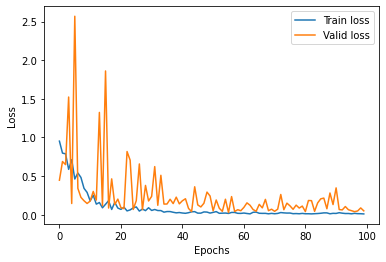

1-year profit: 46.49677346918079%
Operation accuracy: 58.108108108108105%
Run pip install nbformat to save notebook history
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>

In [0]:
# Define the number of epochs to run the model on
hparams.epochs = 100
hparams.lr = 0.01
hparams.dropout = 0.0
hparams.momentum = 0.3

# Configure the current run
run = wandb.init(reinit=True, project='distributed_spf', config=hparams)

# Define the loss function and the model's optimizer
loss_fn = nn.MSELoss()
model = SimpleLSTM(hparams)
optimizer = torch.optim.SGD(model.parameters(), lr=hparams.lr, momentum=hparams.momentum)

# Materialize spark dataframes to DBFS in parqet format
converter_train = make_spark_converter(train_ds)
converter_valid = make_spark_converter(val_ds)
converter_test = make_spark_converter(test_ds)

# Fit the model on training data, and evaluate it on validation split
with converter_train.make_torch_dataloader(
  batch_size=hparams.batch_size, data_loader_fn=partial(data_loader_fn, hparams.window_size), num_epochs=1
) as train_dataloader, converter_valid.make_torch_dataloader(
  batch_size=hparams.batch_size, data_loader_fn=partial(data_loader_fn, hparams.window_size), num_epochs=1
) as valid_dataloader, converter_test.make_torch_dataloader(
  batch_size=hparams.batch_size, data_loader_fn=partial(data_loader_fn, hparams.window_size), num_epochs=1
) as test_dataloader:
  
  train_logs = train(model, optimizer, train_dataloader, valid_dataloader, run, epochs=hparams.epochs)
  plot_loss_history(train_logs)
  
  evaluate_trading_strategy(model, test_dataloader, price_mean, price_std, len(dfs), target_idx=features.index('Adjusted_Close'))

# Log the experiments
run.finish()

##Other regressors

Here we train and evaluate other simpler regressors that are provided directly by PySpark. This is done for comparison of the more articulated LSTM network with these simpler approaches.

In [0]:
tree_predicted_values = fit_evaluate('DecisionTreeRegressor', hparams.window_size, train_ds, test_ds)
evaluate_trading_strategy_ps(tree_predicted_values, features, hparams, price_std, price_mean)

Performance with DecisionTreeRegressor
R2: 0.852, MSE: 0.078
1-year profit: 35.970558703493936%
Operation accuracy: 55.45286506469501%

In [0]:
rf_predicted_values = fit_evaluate('RandomForestRegressor', hparams.window_size, train_ds, test_ds)
evaluate_trading_strategy_ps(rf_predicted_values, features, hparams, price_std, price_mean)

Performance with RandomForestRegressor
R2: 0.803, MSE: 0.104
1-year profit: 51.61961803841207%
Operation accuracy: 57.019064124783355%